# Lab RL: Bank of america

## 1. Imports

In [101]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

## 2. Load data

In [102]:
def load_stock_data(filepath):
    """
    Expects a CSV with columns: ['Date', 'Close', ...].
    Returns a list (or array) of daily closing prices.
    """
    df = pd.read_csv(filepath)
    df = df.sort_values(by='Date')  # ensure ascending date order
    prices = df['Close'].values
    return prices


## 3. Trading environnement

In [103]:
class StockEnv:
    def __init__(self, prices, initial_balance=5000):
        self.prices = prices
        self.initial_balance = initial_balance
        self.reset()
        
    def reset(self):
        self.balance = self.initial_balance
        self.shares = 0
        self.current_step = 0
        self.portfolio_value = self.initial_balance
        return self._get_state()
    
    def _get_state(self):
        # Create state based on price change and current holdings
        if self.current_step >= len(self.prices):
            return (0, 0)  # Return default state at end of episode
            
        price_change = 0 if self.current_step == 0 else \
            (self.prices[self.current_step] - self.prices[self.current_step-1]) / self.prices[self.current_step-1]
        
        # Discretize price change into 5 states (-2: large decrease, -1: small decrease, 
        # 0: no change, 1: small increase, 2: large increase)
        if price_change < -0.02:
            price_state = 0
        elif price_change < -0.01:
            price_state = 1
        elif price_change < 0.01:
            price_state = 2
        elif price_change < 0.02:
            price_state = 3
        else:
            price_state = 4
            
        # Discretize holdings into 3 states (0: no shares, 1: some shares, 2: many shares)
        if self.shares == 0:
            holding_state = 0
        elif self.shares <= 50:
            holding_state = 1
        else:
            holding_state = 2
            
        return (price_state, holding_state)
    
    def step(self, action):
        # Check if episode is done
        if self.current_step >= len(self.prices) - 1:
            return self._get_state(), 0, True
            
        # Actions: 0 = hold, 1 = buy, 2 = sell
        current_price = self.prices[self.current_step]
        shares_to_trade = 10
        old_portfolio_value = self.balance + self.shares * current_price
        
        # Execute action
        if action == 1 and self.balance >= current_price * shares_to_trade:  # Buy
            self.shares += shares_to_trade
            self.balance -= current_price * shares_to_trade
        elif action == 2 and self.shares >= shares_to_trade:  # Sell
            self.shares -= shares_to_trade
            self.balance += current_price * shares_to_trade
            
        # Move to next step
        self.current_step += 1
            
        # Calculate reward (change in portfolio value)
        new_portfolio_value = self.balance + self.shares * self.prices[self.current_step]
        reward = (new_portfolio_value - old_portfolio_value) / old_portfolio_value
        self.portfolio_value = new_portfolio_value
        
        return self._get_state(), reward, False

## 4. Q-Learning

In [104]:
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, epsilon=1.0):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        
        # Initialize Q-table with small random values
        self.q_table = {}
        
    def get_action(self, state):
        # Epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            return np.random.randint(self.action_size)
            
        # Get Q-values for this state
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_size)
        return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state):
        # If states don't exist in Q-table, add them
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.action_size)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(self.action_size)
            
        # Q-learning update
        current_q = self.q_table[state][action]
        next_max_q = np.max(self.q_table[next_state])
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * next_max_q - current_q)
        self.q_table[state][action] = new_q
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


## 5. Train & Test script

In [105]:
def train_agent(prices, episodes=1000):
    env = StockEnv(prices)
    agent = QLearningAgent(state_size=(5,3), action_size=3)
    
    portfolio_values = []
    actions_history = []
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        episode_actions = []
        
        while not done:
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            episode_actions.append(action)
            
        if episode % 10 == 0:
            print(f"Episode {episode}, Final Portfolio Value: {env.portfolio_value:.2f}")
            
        portfolio_values.append(env.portfolio_value)
        actions_history.append(episode_actions)
        
    return agent, portfolio_values, actions_history

def test_agent(agent, prices):
    env = StockEnv(prices)
    state = env.reset()
    done = False
    actions = []
    portfolio_values = [env.portfolio_value]
    
    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        state = next_state
        actions.append(action)
        portfolio_values.append(env.portfolio_value)
        
    return actions, portfolio_values


## 7. Plot results

In [106]:

def plot_results(portfolio_values, actions, prices, title):
    plt.figure(figsize=(15, 10))
    
    # Plot portfolio value
    plt.subplot(2, 1, 1)
    plt.plot(portfolio_values)
    plt.title(f'{title} - Portfolio Value Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Portfolio Value (USD)')
    
    # Plot actions and price
    plt.subplot(2, 1, 2)
    plt.plot(prices, label='Stock Price', alpha=0.5)
    
    # Plot buy and sell points
    for i, action in enumerate(actions):
        if action == 1:  # Buy
            plt.scatter(i, prices[i], color='green', marker='^', alpha=0.5)
        elif action == 2:  # Sell
            plt.scatter(i, prices[i], color='red', marker='v', alpha=0.5)
            
    plt.title(f'{title} - Actions and Stock Price')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price (USD)')
    plt.legend()
    plt.tight_layout()
    plt.show()


## 6. Main script

### a) Load training data (Bank of America)

In [107]:


try:
    bac_data = pd.read_csv('./data/bank_of_america.csv')
    ge_data = pd.read_csv('./data/ge.csv')
    
    # Extract closing prices and ensure they're sorted by date
    bac_data['Date'] = pd.to_datetime(bac_data['Date'])
    ge_data['Date'] = pd.to_datetime(ge_data['Date'])
    
    bac_data = bac_data.sort_values('Date')
    ge_data = ge_data.sort_values('Date')
    
    bac_prices = bac_data['Close'].values
    ge_prices = ge_data['Close'].values
    
    print(f"Loaded {len(bac_prices)} days of Bank of America data")
    print(f"Loaded {len(ge_prices)} days of General Electric data")
    
except Exception as e:
    print(f"Error loading data: {e}")
    raise


Loaded 1257 days of Bank of America data
Loaded 1257 days of General Electric data


### b) Train Q-Learning

In [108]:

# Train on Bank of America data
print("Training on Bank of America data...")
trained_agent, training_portfolio_values, training_actions = train_agent(bac_prices)


Training on Bank of America data...
Episode 0, Final Portfolio Value: 6292.60
Episode 10, Final Portfolio Value: 5166.60
Episode 20, Final Portfolio Value: 6175.40
Episode 30, Final Portfolio Value: 5957.90
Episode 40, Final Portfolio Value: 5511.80
Episode 50, Final Portfolio Value: 5034.90
Episode 60, Final Portfolio Value: 4967.50
Episode 70, Final Portfolio Value: 5035.30
Episode 80, Final Portfolio Value: 4998.50
Episode 90, Final Portfolio Value: 4998.80
Episode 100, Final Portfolio Value: 5014.10
Episode 110, Final Portfolio Value: 4996.30
Episode 120, Final Portfolio Value: 4995.20
Episode 130, Final Portfolio Value: 4997.80
Episode 140, Final Portfolio Value: 5001.30
Episode 150, Final Portfolio Value: 5000.00
Episode 160, Final Portfolio Value: 4994.20
Episode 170, Final Portfolio Value: 4994.40
Episode 180, Final Portfolio Value: 4994.60
Episode 190, Final Portfolio Value: 4998.90
Episode 200, Final Portfolio Value: 4997.20
Episode 210, Final Portfolio Value: 5033.20
Episode

### c) Test Q-Learning

In [109]:

# Test on General Electric data
print("\nTesting on General Electric data...")
test_actions, test_portfolio_values = test_agent(trained_agent, ge_prices)



Testing on General Electric data...


### d) Plot results

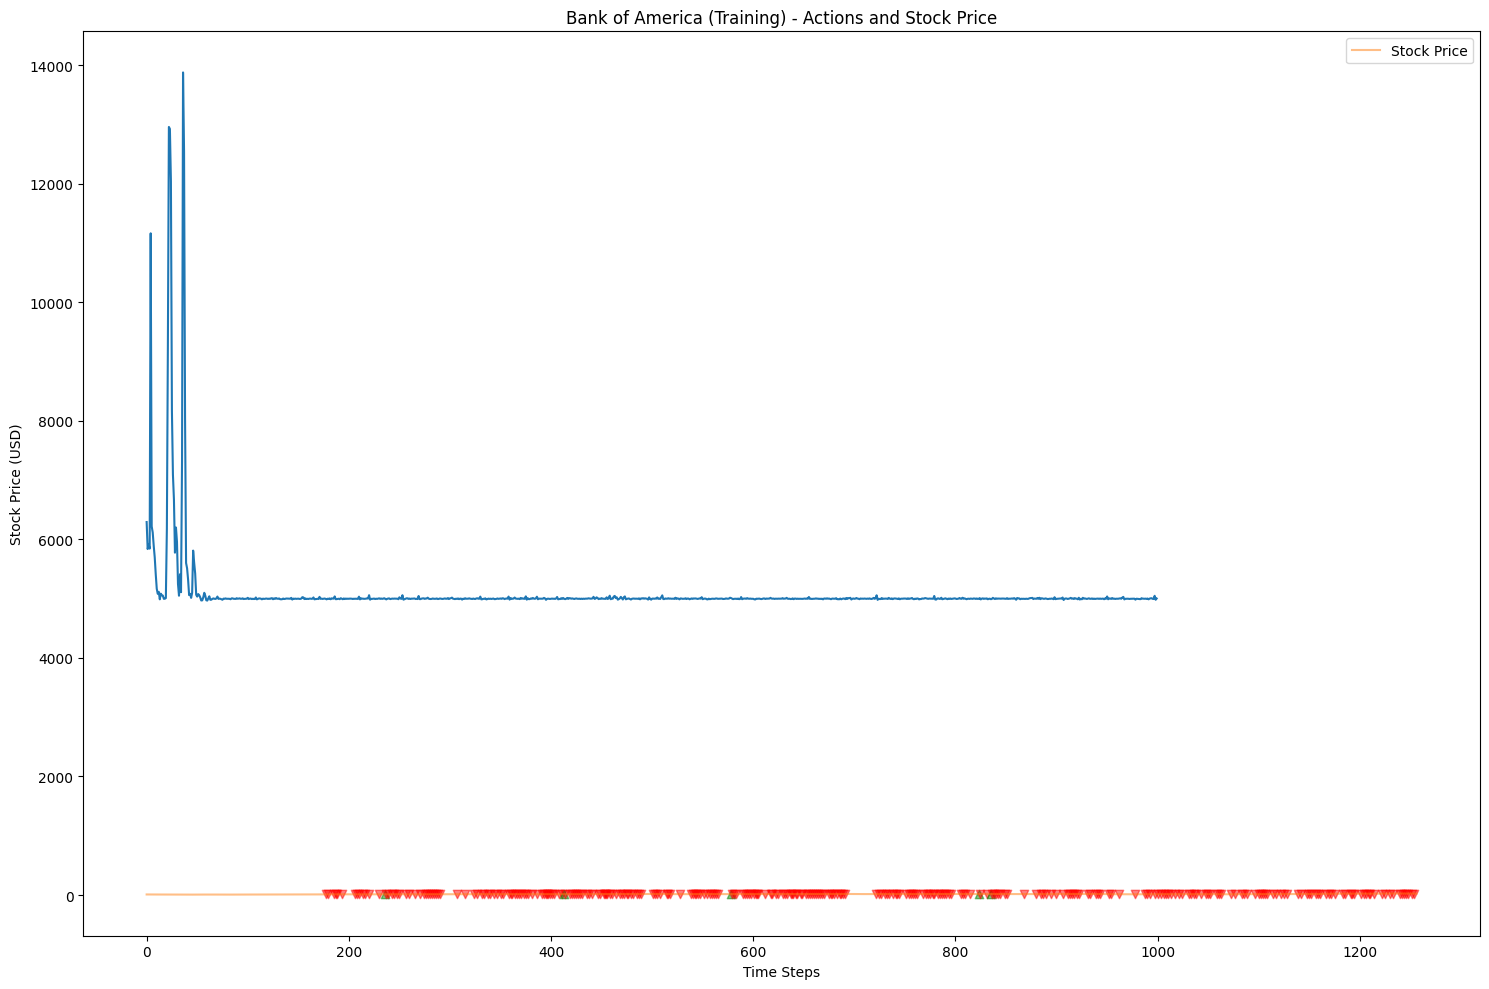

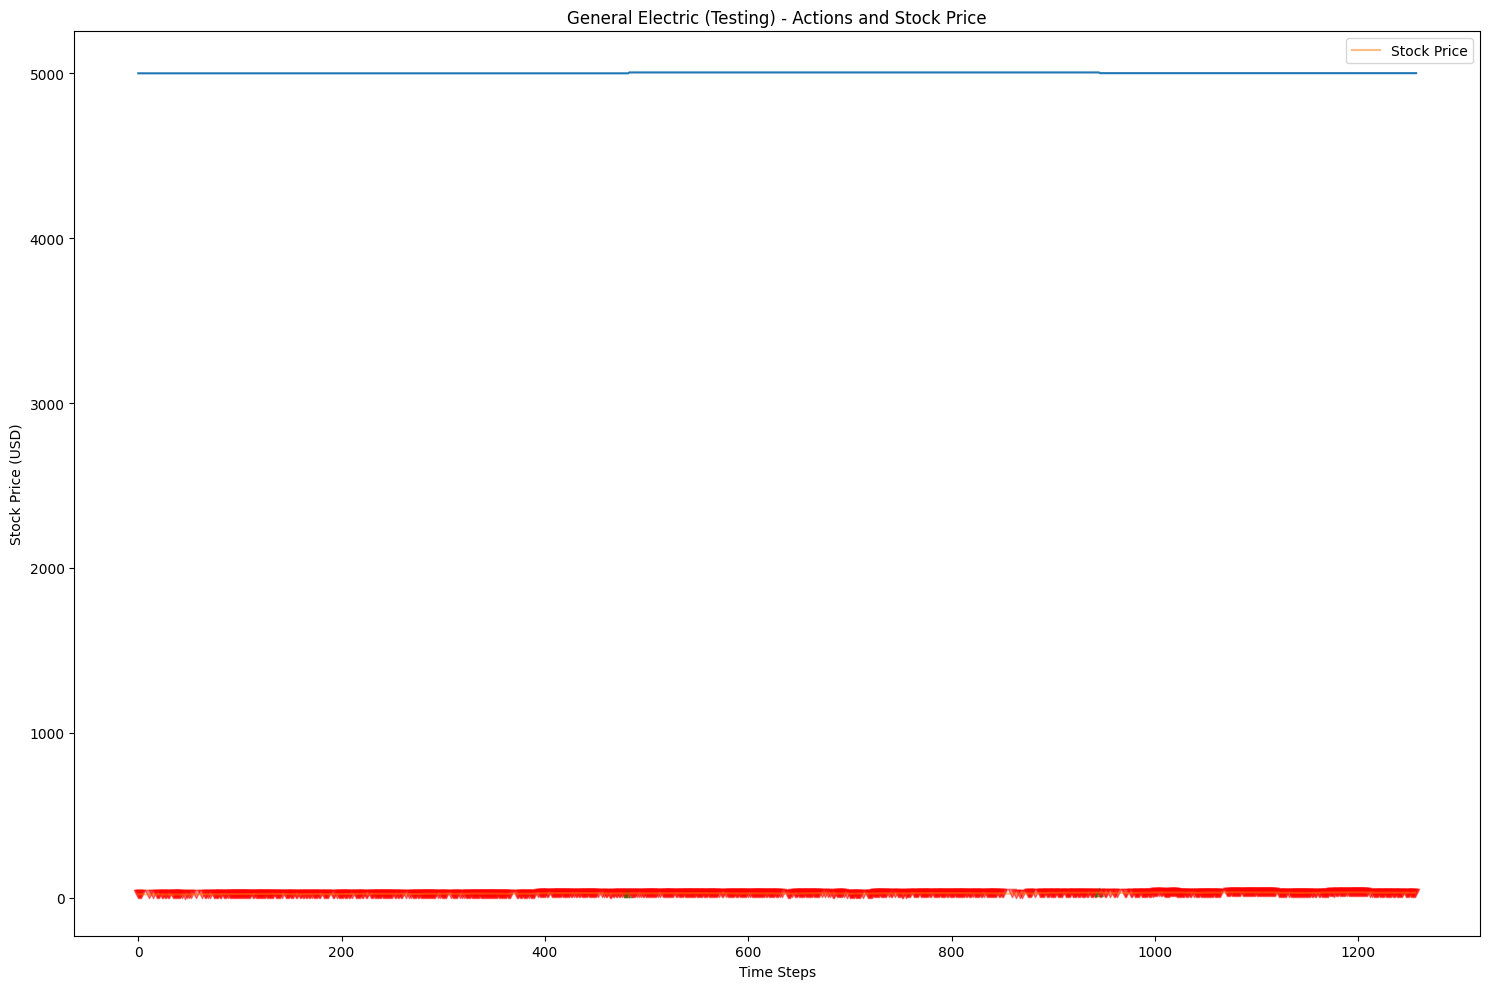

In [110]:
# Plot results
plot_results(training_portfolio_values[-len(bac_prices):], training_actions[-1], 
            bac_prices, "Bank of America (Training)")
plot_results(test_portfolio_values, test_actions, ge_prices, 
            "General Electric (Testing)")